__Author:__ Bram Van de Sande

__Date:__ 1 FEB 2018

__Outline:__ This notebook clarifies the process by which the co-expression modules derived from GENIE3 can be refined into true targetome (i.e. excluding indirect targets of transcription factors). Aka "RcisTarget".

In [1]:
import pickle
import os
import glob
from pyscenic.rnkdb import RankingDatabase
from pyscenic.genesig import GeneSignature, Regulome
from pyscenic.recovery import enrichment, leading_edge
from pyscenic.cistargetome import load_motif2tf_snapshot, generate_features, generate_recovery_curves, filter_features, add_targetome, filter_annotations, add_tf_annotations, add_regulome_score, create_regulomes
from pyscenic.cistargetome import cistargetome
import matplotlib.pyplot as plt
from functools import partial
from dask import delayed
import numpy as np
import pandas as pd
from itertools import repeat

from dask.dot import dot_graph
from dask.multiprocessing import get
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler
from bokeh.io import output_notebook, push_notebook, show
output_notebook()
from dask.diagnostics import visualize

Loading BokehJS ...

In [2]:
DATA_FOLDER="/Users/bramvandesande/Projects/lcb/tmp"
RESOURCES_FOLDER="/Users/bramvandesande/Projects/lcb/resources"
DB_GLOB = "/Users/bramvandesande/Projects/lcb/databases/mm9-*.db"

### Load resources

Co-expression modules were derived from GENIE3 output.

In [3]:
with open(os.path.join(DATA_FOLDER,'modules.pickle'), 'rb') as f:
    modules = pickle.load(f)

In [4]:
len(modules)

5106

Load whole genome ranking databases.

In [5]:
db_fnames = glob.glob(DB_GLOB)
def name(fname):
    return os.path.basename(fname).split(".")[0]
dbs = [RankingDatabase(fname=fname, name=name(fname), nomenclature="MGI") for fname in db_fnames]

In [6]:
len(dbs)

6

Load TF annotations (using a snapshot from motif2TF).

In [7]:
motif2tf = load_motif2tf_snapshot(os.path.join(RESOURCES_FOLDER, "motifs-v9-nr.mgi-m0.001-o0.0.tbl"))

/Users/bramvandesande/miniconda3/envs/pyscenic_dev/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2850: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [8]:
motif2tf.head()

Motif2TF                                               \
                 gene_name motif_similarity_qvalue orthologous_identity   
#motif_id                                                                 
bergman__Abd-B       Hoxa9                  0.0006             1.000000   
bergman__Aef1       Zfp128                  0.0000             0.220264   
bergman__Cf2        Zfp853                  0.0000             0.166667   
bergman__EcR_usp     Nr1h2                  0.0000             0.378924   
bergman__EcR_usp     Nr1h3                  0.0000             0.408989   

                                                                     
                                                        description  
#motif_id                                                            
bergman__Abd-B    gene is annotated for similar motif cisbp__M10...  
bergman__Aef1     motif is annotated for orthologous gene FBgn00...  
bergman__Cf2      motif is annotated for orthologous gene FBgn00...  
bergman__EcR_usp  gene is orthologous to FBgn0000546 in D. melan...  
bergman__EcR_usp  gene is orthologous to FBgn0000546 in D. melan...

### Test pipeline on a sample

Before scaling it via dask to work on the full combinatorial space of databases x modules.

In [9]:
df_features = generate_features(dbs[0], modules[6])

In [10]:
rccs = generate_recovery_curves(df_features)

In [11]:
df_features = filter_features(df_features)

In [12]:
df_features = add_tf_annotations(df_features, motif2tf)

In [13]:
df_features = filter_annotations(df_features)

In [14]:
df_features = add_targetome(df_features, rccs['avg2std'])

In [15]:
df_features = add_regulome_score(df_features)

In [16]:
df_features.head()

Enrichment           Recovery                                \
                    AUC       NES        0         1         2         3   
cisbp__M0998   0.002947  3.192661      0.0  5.005771  5.005771  5.005771   
cisbp__M1032   0.002898  3.109903      0.0  0.000000  5.005771  5.005771   
cisbp__M1058   0.002926  3.157127      0.0  0.000000  5.005771  5.009509   

                                                        ...                 \
                     4         5         6         7    ...           1499   
cisbp__M0998  5.005771  5.005771  5.005771  5.005771    ...     123.009816   
cisbp__M1032  5.005771  5.005771  5.005771  5.005771    ...     113.923246   
cisbp__M1058  5.009509  5.009509  5.009509  5.009509    ...     126.960390   

                                                Metadata  \
                                               Signature   
cisbp__M0998  Regulome for Alx1 (target weight >= 0.001)   
cisbp__M1032  Regulome for Alx1 (target weight >= 0.001)   
cisbp__M1058  Regulome for Alx1 (target weight >= 0.001)   

                                                  Motif2TF  \
                                 Database Factor gene_name   
cisbp__M0998  mm9-500bp-upstream-7species   Alx1      Alx1   
cisbp__M1032  mm9-500bp-upstream-7species   Alx1      Alx1   
cisbp__M1058  mm9-500bp-upstream-7species   Alx1      Alx1   

                                                           \
             motif_similarity_qvalue orthologous_identity   
cisbp__M0998                0.000278                  1.0   
cisbp__M1032                0.000199                  1.0   
cisbp__M1058                0.000594                  1.0   

                                                                 \
                                                    description   
cisbp__M0998  motif similar to cisbp__M1004 ('Alx1[gene ID: ...   
cisbp__M1032  gene is annotated for similar motif cisbp__M10...   
cisbp__M1058  motif similar to cisbp__M1004 ('Alx1[gene ID: ...   

                                                     Enrichment            
                                                             LE     Score  
cisbp__M0998  [(Prrx1, 1.0), (Fosb, 15.0), (Bahcc1, 34.0), (...  0.261412  
cisbp__M1032  [(Prrx1, 2.0), (Fosb, 20.0), (Bahcc1, 36.0), (...  0.265032  
cisbp__M1058  [(Prrx1, 2.0), (Fosb, 3.0), (Tbx2, 40.0), (Bah...  0.234531  

[3 rows x 1511 columns]

In [17]:
create_regulomes(df_features)

[Regulome(name='Regulome for Alx1', nomenclature='MGI', gene2weights=<frozendict {'Tpm1': 1.0, 'Serping1': 1.0, 'Gjb2': 1.0, 'Myl9': 1.0, 'Zic2': 1.0, 'Phlda2': 1.0, 'Irf1': 1.0, 'Rras': 1.0, 'Emilin1': 1.0, 'Samd4': 1.0, 'Gadd45b': 1.0, 'Fosb': 1.0, 'Tpm2': 1.0, 'Epb4.1': 1.0, 'Dnmt3b': 1.0, 'Nrarp': 1.0, 'Prrx1': 1.0, 'Ptgds': 1.0, 'Vim': 1.0, 'Nfatc4': 1.0, 'Gja4': 1.0, 'Fnip2': 1.0, 'Pcdh18': 1.0, 'Myocd': 1.0, 'Icam1': 1.0, 'Prelp': 1.0, 'Obsl1': 1.0, 'Klf4': 1.0, 'Zic1': 1.0, 'Id3': 1.0, 'Sema4b': 1.0, 'Ccnd2': 1.0, 'Errfi1': 1.0, 'Tbx18': 1.0, 'Sdk2': 1.0, 'Tmem200b': 1.0, 'Bahcc1': 1.0, 'H3f3a': 1.0, 'Frmd4b': 1.0, 'Bnc2': 1.0, 'Nfkbiz': 1.0, 'Des': 1.0, 'Tbx2': 1.0, 'Rftn2': 1.0, 'Actn1': 1.0, 'Rbpms2': 1.0, 'Col12a1': 1.0}>, transcription_factor='Alx1', context=('mm9-500bp-upstream-7species', 'target weight >= 0.00'), score=0.26503234510199464)]

The weights/importance from GENIE3 of the genes in the regulomes is lost and should somehow be reintroduced.

### Parallelized pipeline using dask

In [18]:
generate_features = delayed(generate_features)
generate_recovery_curves = delayed(generate_recovery_curves)
add_targetome = delayed(add_targetome)

@delayed
def annotate_features(df_features, motif2tf, nes_threshold):
    return add_regulome_score(filter_annotations(add_tf_annotations(filter_features(df_features, nes_threshold), motif2tf)))

@delayed
def derive_regulomes(dfs):
    return create_regulomes(pd.concat(dfs))

TODO: Avoid having to calculate rccs when there are no annotated enriched features available.

In [19]:
features = [generate_features(db, gs, rank_threshold=1400) for db in dbs[0:2] for gs in modules[6:8]]
rccs = [ generate_recovery_curves(f) for f in features ]
annot_features = [annotate_features(f, motif2tf, nes_threshold=3.0) for f in features]
targetomes = [add_targetome(af, rcc['avg2std']) for af, rcc in zip(annot_features, rccs)]
regulomes = derive_regulomes(targetomes)

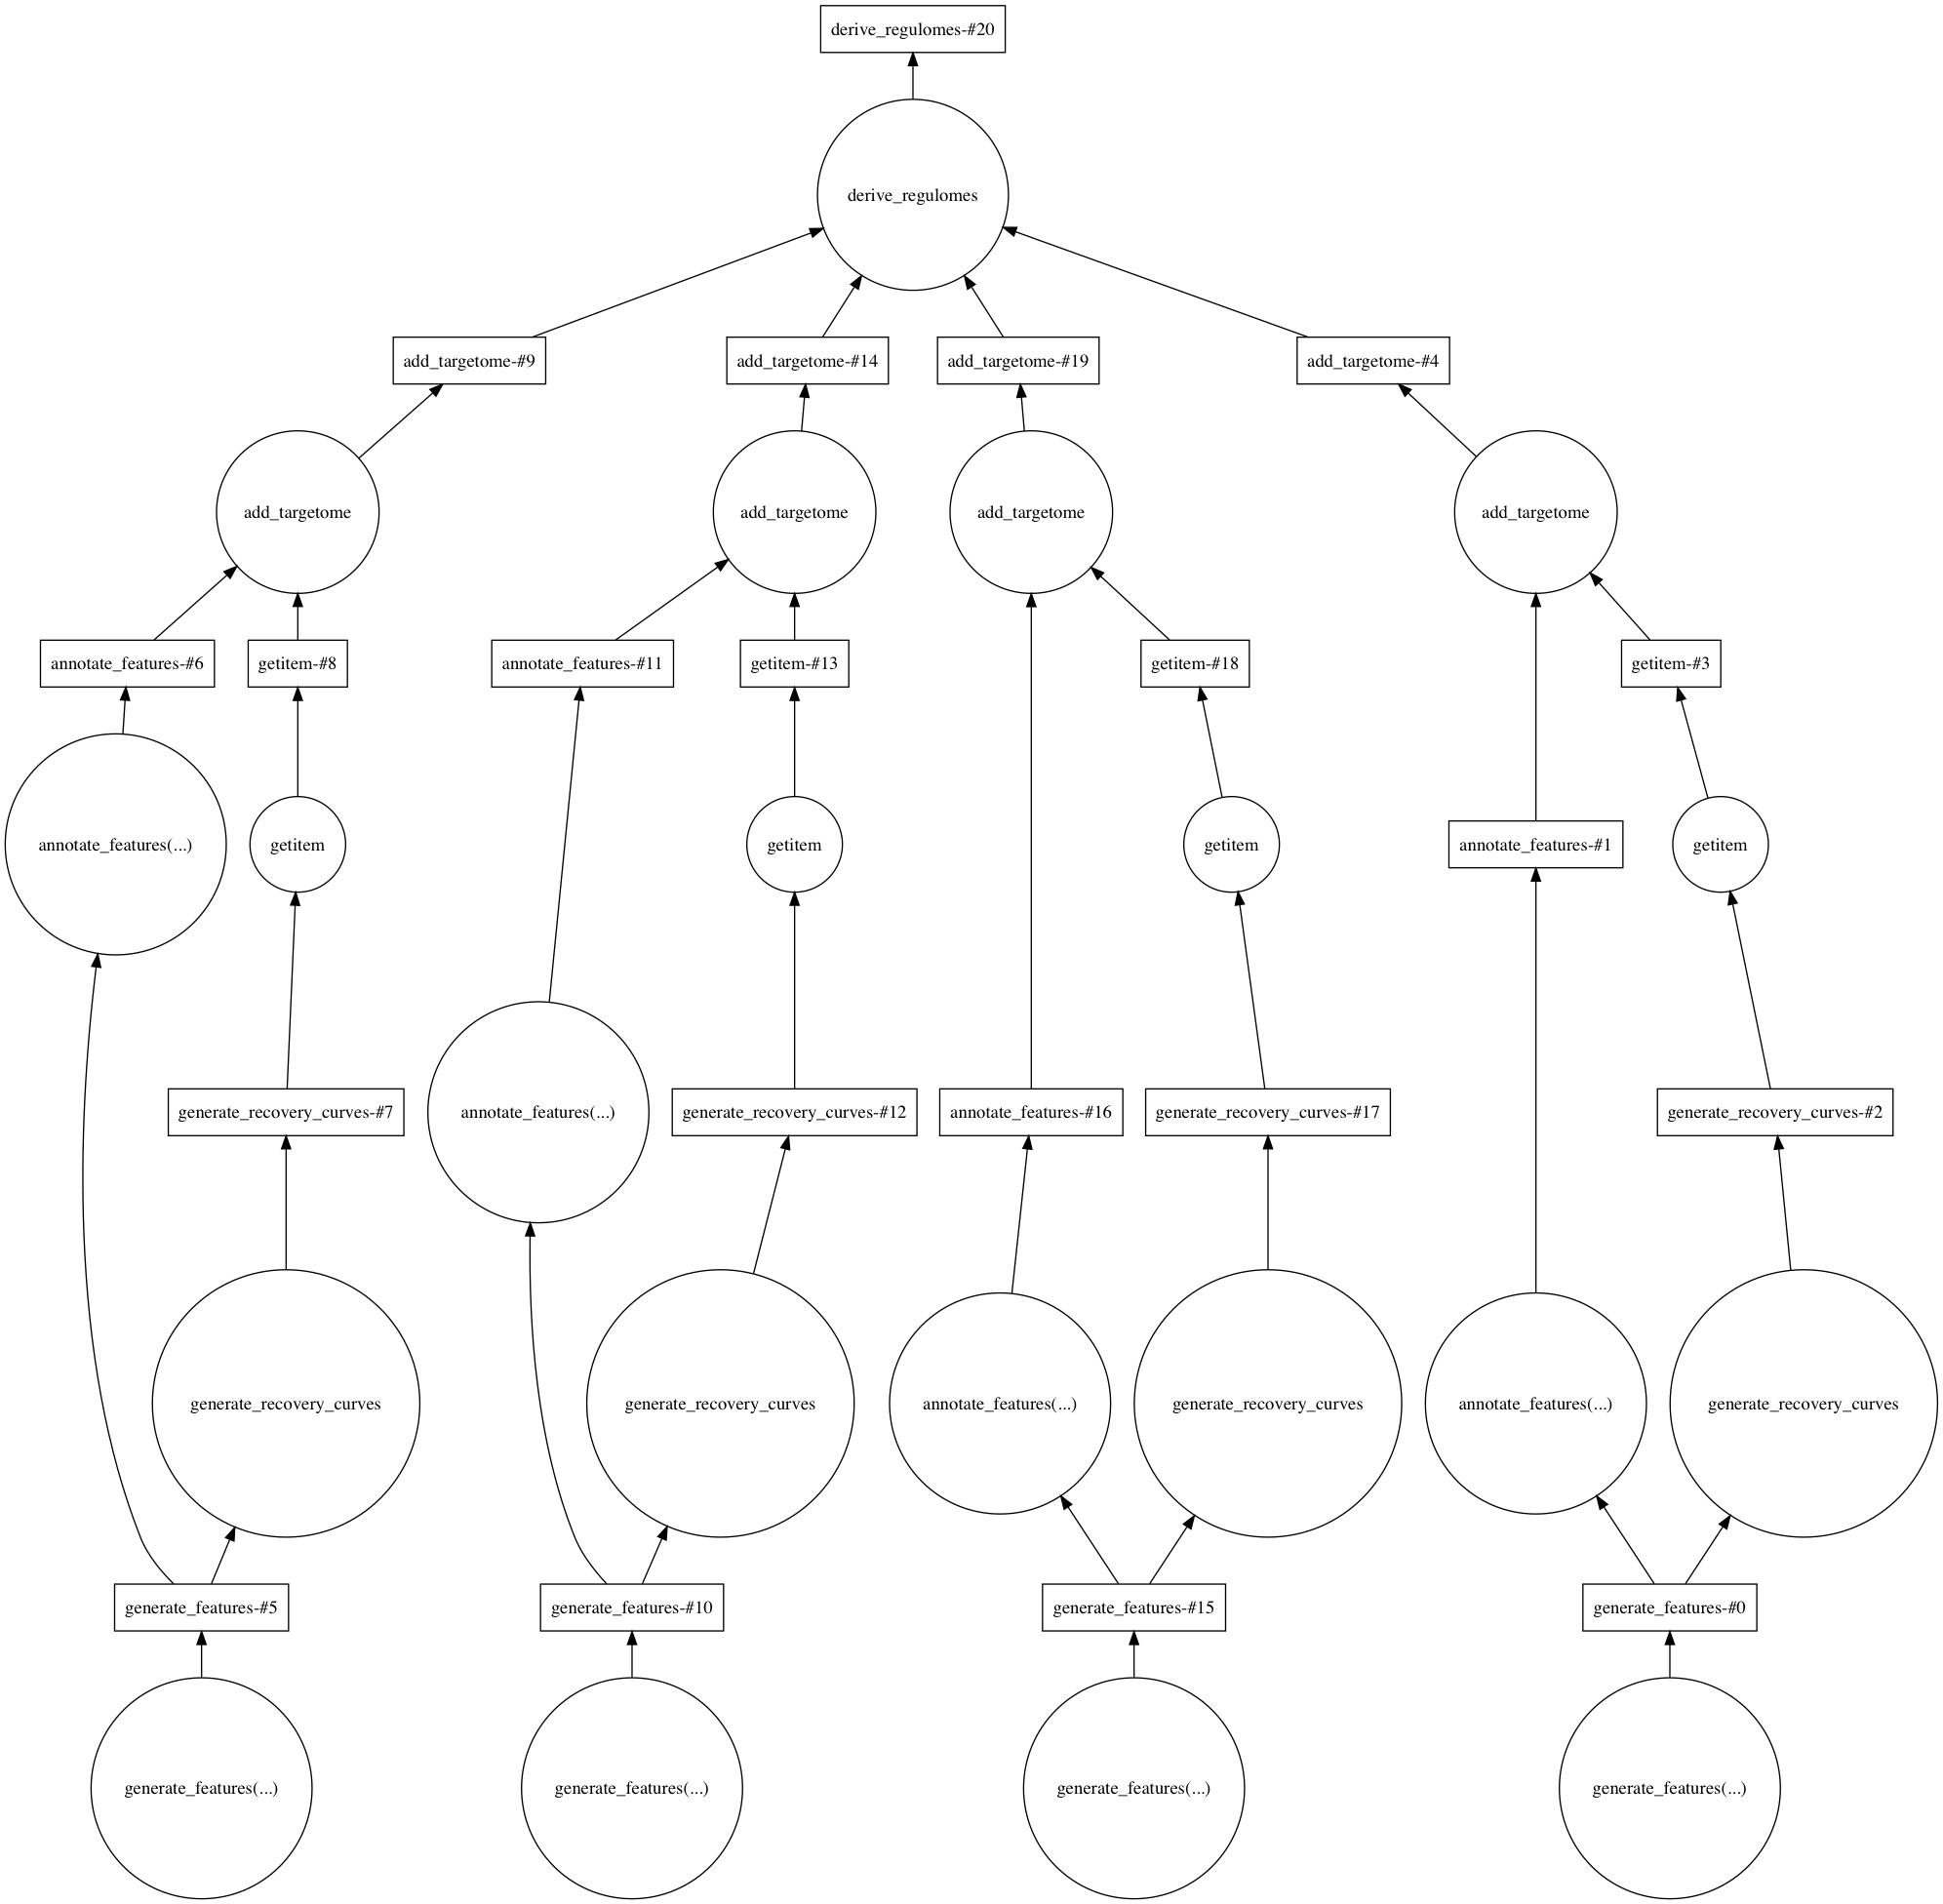

In [20]:
dot_graph(regulomes.dask)

In [21]:
with Profiler() as prof, ResourceProfiler(dt=0.25) as rprof, CacheProfiler() as cprof:
    result = regulomes.compute(get=get, num_workers=4)

In [22]:
visualize([prof, rprof, cprof])

Column(id='bef86873-3f81-430b-9da8-54459d3ff52a', ...)

In [23]:
result

[Regulome(name='Regulome for Alx1', nomenclature='MGI', gene2weights=<frozendict {'Tpm1': 1.0, 'Serping1': 1.0, 'Gjb2': 1.0, 'Myl9': 1.0, 'Zic2': 1.0, 'Phlda2': 1.0, 'Irf1': 1.0, 'Rras': 1.0, 'Emilin1': 1.0, 'Samd4': 1.0, 'Gadd45b': 1.0, 'Fosb': 1.0, 'Tpm2': 1.0, 'Epb4.1': 1.0, 'Dnmt3b': 1.0, 'Nrarp': 1.0, 'Prrx1': 1.0, 'Ptgds': 1.0, 'Vim': 1.0, 'Nfatc4': 1.0, 'Gja4': 1.0, 'Fnip2': 1.0, 'Pcdh18': 1.0, 'Myocd': 1.0, 'Icam1': 1.0, 'Prelp': 1.0, 'Obsl1': 1.0, 'Klf4': 1.0, 'Zic1': 1.0, 'Id3': 1.0, 'Sema4b': 1.0, 'Ccnd2': 1.0, 'Errfi1': 1.0, 'Tbx18': 1.0, 'Sdk2': 1.0, 'Tmem200b': 1.0, 'Bahcc1': 1.0, 'H3f3a': 1.0, 'Frmd4b': 1.0, 'Bnc2': 1.0, 'Nfkbiz': 1.0, 'Des': 1.0, 'Tbx2': 1.0, 'Rftn2': 1.0, 'Actn1': 1.0, 'Rbpms2': 1.0, 'Col12a1': 1.0}>, transcription_factor='Alx1', context=('mm9-500bp-upstream-7species', 'target weight >= 0.00'), score=0.26503234510199464)]

In [24]:
import pickle

with open(os.path.join(DATA_FOLDER, 'regulomes.pickle'), 'wb') as f:
    pickle.dump(result, f, pickle.HIGHEST_PROTOCOL)

Test on larger sample:
1. One database

In [27]:
dbs

[RankingDatabase(name="mm9-500bp-upstream-7species",n_features=24453),
 RankingDatabase(name="mm9-tss-centered-10kb-10species",n_features=24453),
 RankingDatabase(name="mm9-tss-centered-10kb-7species",n_features=24453),
 RankingDatabase(name="mm9-tss-centered-5kb-10species",n_features=24453),
 RankingDatabase(name="mm9-500bp-upstream-10species",n_features=24453),
 RankingDatabase(name="mm9-tss-centered-5kb-7species",n_features=24453)]

In [34]:
def derive_definition(regulome):
    name = regulome.name
    return name[name.find("(")+1:-1]

from collections import defaultdict

def2modules = defaultdict(set)
for module in modules:
    def2modules[derive_definition(module)].add(module)

In [35]:
def2modules.keys()

dict_keys(['target weight >= 0.001', 'target weight >= 0.005', 'target in top 50', 'factor in top 5', 'factor in top 10', 'factor in top 50'])

In [36]:
len(def2modules['factor in top 50'])

857

In [ ]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    regulomes = cistargetome([dbs[3]], list(def2modules['factor in top 50']), motif2tf, num_workers=8)

[##########                              ] | 25% Completed | 57min 15.4s

In [ ]:
with open(os.path.join(DATA_FOLDER, 'regulomes.pickle'), 'wb') as f:
    pickle.dump(regulomes, f, pickle.HIGHEST_PROTOCOL)